<a href="https://colab.research.google.com/github/sgangoly/General-Relativity/blob/master/LIGO_GW/GW_CH4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3'
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

     |████████████████████████████████| 28.5MB 136kB/s 
     |████████████████████████████████| 3.1MB 46.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 1.6MB 40.7MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 798kB 41.5MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 2.7MB 42.3MB/s 
     |████████████████████████████████| 1.4MB 9.0MB/s 


In [2]:
! pip install -q 'bilby==0.6.1' 'gwpy==1.0.1'

     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 


In [0]:
%matplotlib inline
import numpy
import pylab
from pycbc.waveform import get_td_waveform
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.filter import highpass_fir, matched_filter
from pycbc.psd import welch, interpolate
from pycbc.filter import resample_to_delta_t, highpass

In [4]:
# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

--2020-06-05 13:18:40--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  20.0MB/s    in 13s     

2020-06-05 13:18:54 (18.2 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



In [5]:
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import TimeSeriesDict
ts1 = TimeSeriesDict.read('challenge3.gwf', ['H1:CHALLENGE3', 'L1:CHALLENGE3'])
print (ts1)

TimeSeriesDict([('H1:CHALLENGE3', <TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
             ...,  4.46471052e-19,  5.07624678e-19,
              4.98623016e-19]
            unit=Unit("ct"),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.00024414 s>,
            name='H1:CHALLENGE3',
            channel=<Channel("H1:CHALLENGE3", 4096.0 Hz) at 0x7fc7f0b96fd0>)>), ('L1:CHALLENGE3', <TimeSeries([-1.18224332e-18, -2.01299104e-18, -2.63431559e-18,
             ...,  7.92506935e-19,  1.44200716e-19,
             -4.83879726e-19]
            unit=Unit("ct"),
            t0=<Quantity 0. s>,
            dt=<Quantity 0.00024414 s>,
            name='L1:CHALLENGE3',
            channel=<Channel("L1:CHALLENGE3", 4096.0 Hz) at 0x7fc7f0b95cf8>)>)])


In [7]:
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')
pyd = pycbc_strain
print(pyd)

[-3.04517369e-19 -3.35465069e-19 -3.35210566e-19 ...
  4.46471052e-19  5.07624678e-19  4.98623016e-19]


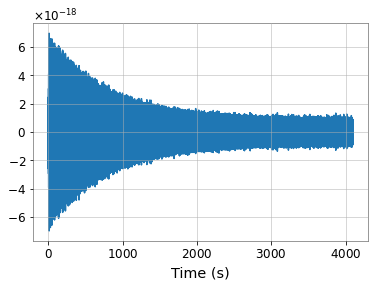

In [8]:
pylab.plot(pyd.sample_times, pyd)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
#pyd = highpass(pyd, 15.0)
#pyd = resample_to_delta_t(pyd, 1.0/2048)
#from pycbc.catalog import Merger
#from pycbc.filter import resample_to_delta_t, highpass
#pylab.plot(pyd.sample_times, pyd)
#pylab.xlabel('Time (s)')
#pylab.show()

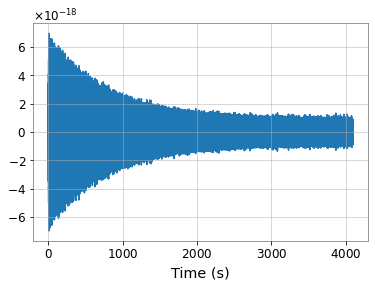

In [9]:
conditioned = pyd.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)

Text(0, 0.5, 'Strain')

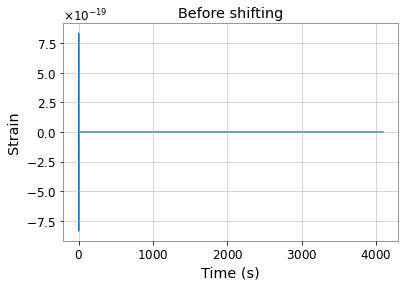

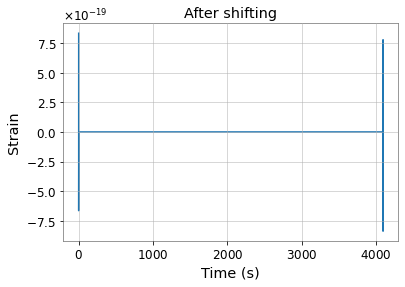

In [11]:
from pycbc.waveform import get_td_waveform

m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

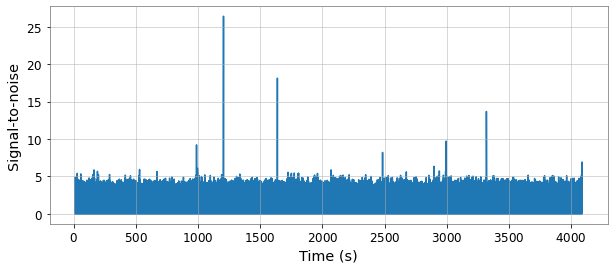

We found a signal at 1204.702392578125s with SNR 26.392513928226062


In [12]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [13]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

/usr/local/lib/python3.6/dist-packages/bilby/core/utils.py:966: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use(backend, warn=False)


In [14]:
print(bilby.__version__)

0.6.1:


In [0]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [16]:
hs1 = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")
print (hs1)

TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
            ...,  4.46471052e-19,  5.07624678e-19,
             4.98623016e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE3,
           channel: H1:CHALLENGE3)


In [17]:
ls1 = TimeSeries.read('challenge3.gwf', channel="L1:CHALLENGE3")
print (ls1)

TimeSeries([-1.18224332e-18, -2.01299104e-18, -2.63431559e-18,
            ...,  7.92506935e-19,  1.44200716e-19,
            -4.83879726e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: L1:CHALLENGE3,
           channel: L1:CHALLENGE3)


In [20]:
sampling_rate=2048 #needs to be high enough for the signals found in steps above
duration=8 #needs to be long enough for the signals found in steps above
start_time=100 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    interferometers.append(ifo)

13:33 bilby INFO    : Reading data from frame file challenge3.gwf
13:33 bilby INFO    : Successfully loaded H1:CHALLENGE3.
13:33 bilby INFO    : Reading data from frame file challenge3.gwf
13:33 bilby INFO    : Successfully loaded L1:CHALLENGE3.


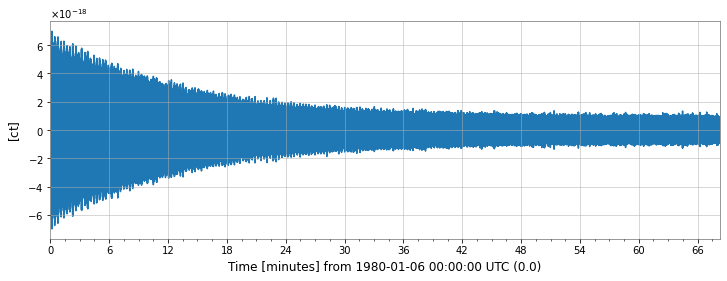

In [25]:
%matplotlib inline
hs1.plot()
plt.show()

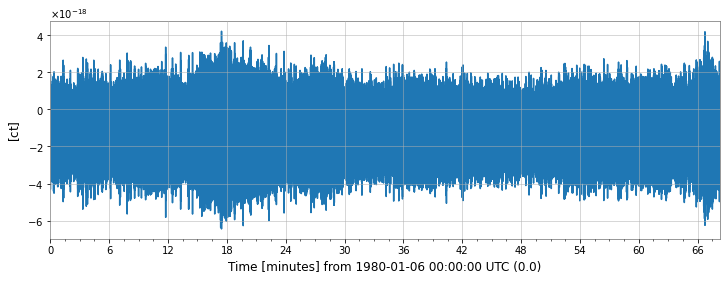

In [26]:
%matplotlib inline
ls1.plot()
plt.show()

In [0]:
H1.set_strain_data_from_gwpy_timeseries(hs1)
L1.set_strain_data_from_gwpy_timeseries(ls1)

In [30]:
psd_duration = duration 
psd_start_time = start_time - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

ValueError: ignored